In [1]:
from fenics import *
from dolfin import *
#from mshr import *
import matplotlib.pyplot as plt


comm = MPI.comm_world
rank = MPI.rank(comm)

data = HDF5File(comm, f"data_mpi_time_3600_D_1.99_count_12.h5", 'r')

mesh = Mesh()
data.read(mesh, "mesh", False)

In [2]:
nx = 60
ny = 100
LX = 120 
LY = 200

# Sub domain for Periodic boundary condition
class PeriodicBoundary(SubDomain):

    def inside(self, x, on_boundary):
        return bool((near(x[0], 0) or near(x[1], 0)) and
                (not ((near(x[0], 0) and near(x[1], LY)) or
                        (near(x[0], LX) and near(x[1], 0)))) and on_boundary)

    def map(self, x, y):
        if near(x[0], LX) and near(x[1], LY):
            y[0] = x[0] - LX
            y[1] = x[1] - LY
        elif near(x[0], LX):
            y[0] = x[0] - LX
            y[1] = x[1]
        else:   # near(x[1], 127)
            y[0] = x[0]
            y[1] = x[1] - LY

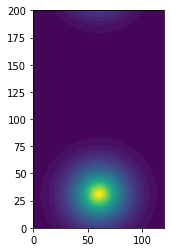

In [3]:
V = VectorElement("Lagrange", mesh.ufl_cell(), 1, dim = 2)
Q = FiniteElement("Lagrange", mesh.ufl_cell(), 1)
MFS = FunctionSpace(mesh, MixedElement([Q, V]), constrained_domain = PeriodicBoundary())

VFS = FunctionSpace(mesh, V, constrained_domain = PeriodicBoundary())
FS  = FunctionSpace(mesh, Q, constrained_domain = PeriodicBoundary())

u_new = Function(MFS) 
w = Function(FS)
(rho_new, tau_new) = split(u_new)

time = 0
data.read(u_new, f"u_new/Vector/vector_{time}")
plot(rho_new)

In [4]:
import numpy as np

x = np.linspace(0, LX, nx)
y = np.linspace(0, LY, ny)
xx, yy = np.meshgrid(x, y, sparse = False, indexing = 'ij')

In [5]:
total_time = 3600
step = 2
start = 0

time = np.arange(0, total_time, step)
Inertia = []
y_pos = []

def calculate_inertia(rho_array):
    
    test_rho = np.zeros([nx, ny])
    thres = 1.07
    mask = rho_array > thres
    test_rho = np.where(mask, rho_array, 0)

    cmx, cmy, M = 0, 0, 0
    for i in range(nx):
        for j in range(ny):
            cmx = cmx + i*test_rho[i, j]
            cmy = cmy + j*test_rho[i, j]
            M = M + test_rho[i, j]
    cmx = cmx/M
    cmy = cmy/M
    Ixx, Iyy, Ixy = 0, 0, 0

    for x in range(nx):
        for y in range(ny):
            Ixx = Ixx + test_rho[x, y]*(y - cmy)**2
            Iyy = Iyy + test_rho[x, y]*(x - cmx)**2
            Ixy = Ixy - test_rho[x, y]*(x - cmx)*(y - cmy)
            
    I = np.asarray([[Ixx, Ixy], [Ixy, Iyy]])
    eigenvalues, eigenvectors = np.linalg.eig(I)
    
    inertia = eigenvalues[1]/eigenvalues[0]
    
    return inertia


def roll(x_roll, y_roll, rho_ar):
    
    # Perform a circular shift along rows (axis=0)
    shifted_rows = np.roll(rho_ar, shift=x_roll, axis=0)

    # Perform a circular shift along columns (axis=1)
    rho_shifted = np.roll(shifted_rows, shift=y_roll, axis=1)
    
    return rho_shifted

    
for t in range(start, total_time, step):
    
    if(t % 100 == 0):
        print(f"step : {t}", flush = True)
    
    data.read(u_new, f"u_new/Vector/vector_{t}")

    rho, tau = u_new.split()


    rho_f = np.vectorize(rho)
    rho_ar = rho_f(xx,yy)

    max_index = np.unravel_index(np.argmax(rho_ar), rho_ar.shape)

    x0 = max_index[0]
    y0 = max_index[1]

    rho_ar = roll(int(np.shape(rho_ar)[0]/2) - x0, int(np.shape(rho_ar)[1]/2) - y0, rho_ar)

    y_pos.append(2*y0)
#     max_index = np.unravel_index(np.argmax(rho_ar), rho_ar.shape)

#     x0 = max_index[0]
#     y0 = max_index[1]
#     print(f"rolled coordinates are x0:{x0} and y0:{y0}", flush = True)
#     print(np.shape(rho_ar))
    Inertia.append(calculate_inertia(rho_ar))



step : 0
step : 100
step : 200
step : 300
step : 400
step : 500
step : 600
step : 700
step : 800
step : 900
step : 1000
step : 1100
step : 1200
step : 1300
step : 1400
step : 1500
step : 1600
step : 1700
step : 1800
step : 1900
step : 2000
step : 2100
step : 2200
step : 2300
step : 2400
step : 2500
step : 2600
step : 2700
step : 2800
step : 2900
step : 3000
step : 3100
step : 3200
step : 3300
step : 3400
step : 3500


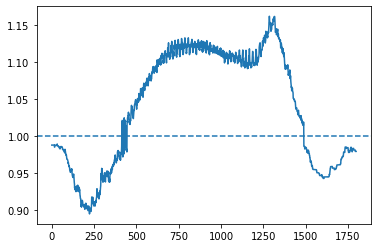

In [7]:
plt.plot(Inertia)
plt.axhline(y = 1, linestyle = '--')

In [9]:
np.savez(f"inertia_distance.npz", y_pos = y_pos, Inertia = Inertia)

In [32]:
x = np.linspace(-np.pi, np.pi, 100)
y = np.tan(x)

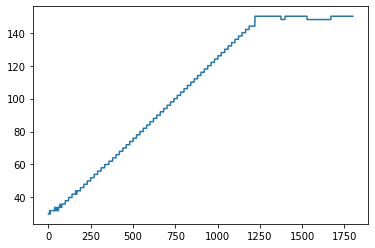

In [8]:
plt.plot(y_pos)

In [34]:
x

array([-3.14159265, -3.07812614, -3.01465962, -2.9511931 , -2.88772658,
       -2.82426006, -2.76079354, -2.69732703, -2.63386051, -2.57039399,
       -2.50692747, -2.44346095, -2.37999443, -2.31652792, -2.2530614 ,
       -2.18959488, -2.12612836, -2.06266184, -1.99919533, -1.93572881,
       -1.87226229, -1.80879577, -1.74532925, -1.68186273, -1.61839622,
       -1.5549297 , -1.49146318, -1.42799666, -1.36453014, -1.30106362,
       -1.23759711, -1.17413059, -1.11066407, -1.04719755, -0.98373103,
       -0.92026451, -0.856798  , -0.79333148, -0.72986496, -0.66639844,
       -0.60293192, -0.53946541, -0.47599889, -0.41253237, -0.34906585,
       -0.28559933, -0.22213281, -0.1586663 , -0.09519978, -0.03173326,
        0.03173326,  0.09519978,  0.1586663 ,  0.22213281,  0.28559933,
        0.34906585,  0.41253237,  0.47599889,  0.53946541,  0.60293192,
        0.66639844,  0.72986496,  0.79333148,  0.856798  ,  0.92026451,
        0.98373103,  1.04719755,  1.11066407,  1.17413059,  1.23

In [26]:
total_time = 3600
step = 2
start = 0

w_ = Function(FS)
w_y = []
for i in range(start, total_time, step):
    if(i % 100 == 0):
        print(f"step : {i}", flush = True)
    
    data.read(w, f"w/Vector/vector_{i}")
    data.read(u_new, f"u_new/Vector/vector_{i}")

    rho = project(rho_new, FS)
    test = []
    for j in range(len(rho.vector()[:])):
        if(rho.vector()[j] > 1.4):
            test.append(w.vector()[j]**2)
        else:
            test.append(0)
    
    w_.vector().set_local(test)

    vertex_values = w_.compute_vertex_values(mesh)
    max_value_index = vertex_values.argmax()
    max_vertex_coords = mesh.coordinates()[max_value_index]
    
    w_y.append(max_vertex_coords[1])

step : 0
step : 100
step : 200
step : 300
step : 400
step : 500
step : 600
step : 700
step : 800
step : 900
step : 1000
step : 1100
step : 1200
step : 1300
step : 1400
step : 1500
step : 1600
step : 1700
step : 1800
step : 1900
step : 2000
step : 2100
step : 2200
step : 2300
step : 2400
step : 2500
step : 2600
step : 2700
step : 2800
step : 2900
step : 3000
step : 3100
step : 3200
step : 3300
step : 3400
step : 3500


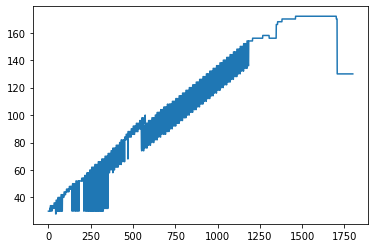

In [27]:
plt.plot(w_y)

In [28]:
np.savez(f"w_pos.npz", w_pos = w_y)

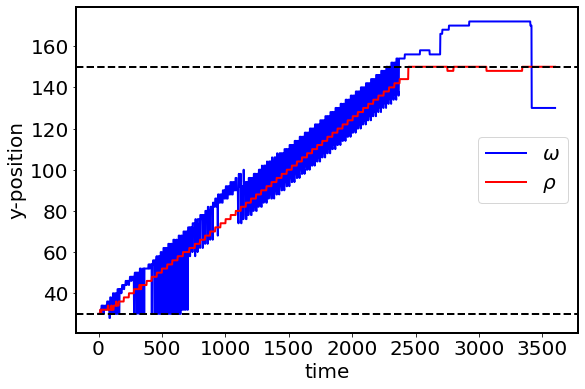

In [51]:
time = np.linspace(0, 3600, len(w_y))

plt.figure(figsize = (9, 6))
plt.plot(time, w_y, label = r'$\omega$', linewidth = 2, color = 'b')
plt.plot(time, y_pos, label = r'$\rho$', linewidth = 2, color = 'r')
plt.legend(fontsize = 20)

plt.xlabel("time", fontsize = 20)
plt.ylabel("y-position", fontsize = 20)
plt.tick_params(axis = 'both', labelsize = 20)
plt.axhline(y = 30, linestyle = '--', color = 'k', linewidth = 2)
plt.axhline(y = 150, linestyle = '--', color = 'k', linewidth = 2)
plt.gca().spines['left'].set_linewidth(2)  # Set left axis line width
plt.gca().spines['bottom'].set_linewidth(2)  # Set bottom axis line width
plt.gca().spines['right'].set_linewidth(2)  # Set right axis line width
plt.gca().spines['top'].set_linewidth(2)  # Set top axis line width

plt.savefig(f"w_pos_rho_pos.png", dpi = 300)

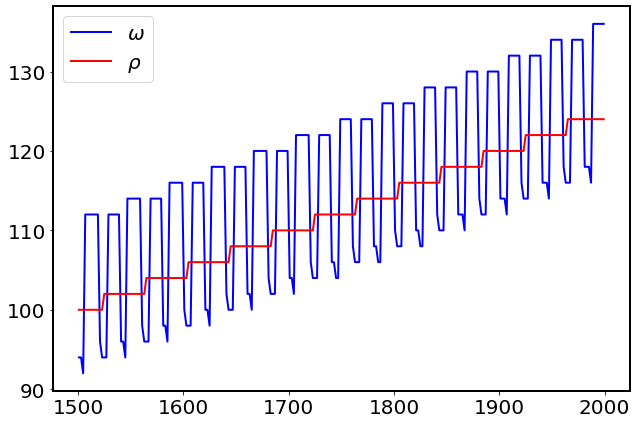

In [53]:
start = 750
end = 1000
# time = np.linspace(2*start, 2*end, end - start + 1)

plt.figure(figsize = (9, 6))
plt.plot(time[start:end], w_y[start:end], label = r'$\omega$', linewidth = 2, color = 'b')
plt.plot(time[start:end], y_pos[start:end], label = r'$\rho$', linewidth = 2, color = 'r')
plt.legend(fontsize = 20)

# plt.xlabel("time", fontsize = 20)
# plt.ylabel("y-position", fontsize = 20)
plt.tick_params(axis = 'both', labelsize = 20)
# plt.axhline(y = 30, linestyle = '--', color = 'k', linewidth = 2)
# plt.axhline(y = 150, linestyle = '--', color = 'k', linewidth = 2)
plt.gca().spines['left'].set_linewidth(2)  # Set left axis line width
plt.gca().spines['bottom'].set_linewidth(2)  # Set bottom axis line width
plt.gca().spines['right'].set_linewidth(2)  # Set right axis line width
plt.gca().spines['top'].set_linewidth(2)  # Set top axis line width
plt.tight_layout()
plt.savefig(f"w_pos_rho_pos_inset.png", dpi = 300)